# Recurrent Neural Network


In [20]:
## Global imports
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

print("Tested Tensorflow Version: 1.15")
print("Current Tensorflow Version:", tf.__version__)

Tested Tensorflow Version: 1.15
Current Tensorflow Version: 2.0.0


## Data Preparation


In [39]:
def load_data(filename, verbose=False):
    with open(filename, 'rb') as fid:
        text = fid.read()
        pass
    np_text = np.array(list(text))
    vocab = np.unique(list(text))
    vocab_dict = {c:i for i, c in enumerate(vocab)}
    vec_text = np.array([vocab_dict[c] for c in np_text])
    if verbose:
        print("\n--- Plain Text:", len(text), "---\n", text[:100].decode('utf-8'), "...")
        print("\n--- Numpy Array:", np_text.shape, "---\n", np_text[:100], "...")
        print("\n--- Vocabular:", vocab.shape, "---\n", vocab[:10], "...")
        print("\n--- Dictionary ---\n", vocab_dict)
        print("\n--- Vectorized Text:", vec_text.shape, "---\n", vec_text[:100], "...")
    return vec_text, vocab, vocab_dict

## Run!
val, _, _ = load_data('data/shakespeare_valid.txt', True)
train, vocab, vocab_dict = load_data('data/shakespeare_train.txt')


--- Plain Text: 229972 ---
 DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The a ...

--- Numpy Array: (229972,) ---
 [ 68  85  75  69  32  79  82  83  73  78  79  58  13  10  73 102  32 109
 117 115 105  99  32  98 101  32 116 104 101  32 102 111 111 100  32 111
 102  32 108 111 118 101  44  32 112 108  97 121  32 111 110  59  13  10
  71 105 118 101  32 109 101  32 101 120  99 101 115 115  32 111 102  32
 105 116  44  32 116 104  97 116  44  32 115 117 114 102 101 105 116 105
 110 103  44  13  10  84 104 101  32  97] ...

--- Vocabular: (63,) ---
 [10 13 32 33 39 44 45 46 58 59] ...

--- Dictionary ---
 {10: 0, 13: 1, 32: 2, 33: 3, 39: 4, 44: 5, 45: 6, 46: 7, 58: 8, 59: 9, 63: 10, 65: 11, 66: 12, 67: 13, 68: 14, 69: 15, 70: 16, 71: 17, 72: 18, 73: 19, 74: 20, 75: 21, 76: 22, 77: 23, 78: 24, 79: 25, 80: 26, 81: 27, 82: 28, 83: 29, 84: 30, 85: 31, 86: 32, 87: 33, 88: 34, 89: 35, 90: 36, 97: 37, 98: 38, 99: 39, 100: 40, 101: 41, 102: 42, 103

### Create Tensorflow Datagenerators

In [3]:
def mapping(chunk):
    y = chunk[:-1]
    t = chunk[1:]
    return y, t

def create_datagenerator(data, chunk_sz, batch_sz, buffer_sz):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.batch(chunk_sz+1, drop_remainder=True)
    dataset = dataset.map(mapping)
    dataset = dataset.shuffle(buffer_sz).batch(batch_sz, drop_remainder=True)
    return dataset

## Run!
chunk_size = 100
batch_size = 64

train_set = create_datagenerator(train, chunk_size, batch_size, buffer_sz=1000)
val_set = create_datagenerator(train, chunk_size, batch_size, buffer_sz=200)

print(val_set)
for batch in val_set.take(1):
    print("\n--- Input Y: ---\n", ''.join([vocab[i] for i in batch[0].numpy()[0]]))
    print("\n--- Target T: ---\n", ''.join([vocab[i] for i in batch[1].numpy()[0]]))

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int32, tf.int32)>

--- Input Y: ---
 
This is strange.

MARCIUS:
Go, get you home, you fragments!

Messenger:
Where's Caius Marcius?

MAR

--- Target T: ---
 This is strange.

MARCIUS:
Go, get you home, you fragments!

Messenger:
Where's Caius Marcius?

MARC


## Setup a SimpleRNN

In [4]:
def setup_rnn(inp_dim, emb_dim, units, batch_sz):
    model = tf.keras.Sequential()
    model.add(layers.Embedding(inp_dim, emb_dim, batch_input_shape=[batch_sz, None]))
    #model.add(layers.SimpleRNN(units))
    model.add(layers.GRU(units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer='glorot_uniform'
    ))
    model.add(layers.Dense(inp_dim))
    return model

## Run!
inp_dim = vocab.size
emb_dim = 256
units = 1024
batch_size = 64

if ('model' in globals()):
    print("Clean up old model!")
    tf.keras.backend.clear_session()
    del model

model = setup_rnn(inp_dim, emb_dim, units, batch_size)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           17152     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 67)            68675     
Total params: 4,024,131
Trainable params: 4,024,131
Non-trainable params: 0
_________________________________________________________________


## Train a SimpleRNN



In [22]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

def loss(labels, logits):
    return sparse_categorical_crossentropy(labels, logits, from_logits=True)

def run_training(model, trainset, valset, epochs, checkpoint):
    mc = ModelCheckpoint(
        filepath=checkpoint,
        save_weights_only=True
    )
    model.compile(optimizer='adam', loss=loss)
    return model.fit(trainset, epochs=epochs, validation_data=valset, callbacks=[mc])

## Run!
epochs = 10
checkpoint = './models/rnn_{epoch}'
history = run_training(model, train_set, val_set, epochs, checkpoint)

Epoch 1/10
673/673 [==============================] - 109s 162ms/step - loss: 1.1393 - val_loss: 0.0000e+00
Epoch 2/10
673/673 [==============================] - 109s 162ms/step - loss: 1.1403 - val_loss: 1.2012
Epoch 3/10
673/673 [==============================] - 109s 162ms/step - loss: 1.1436 - val_loss: 1.2022
Epoch 4/10
673/673 [==============================] - 109s 163ms/step - loss: 1.1461 - val_loss: 1.2011
Epoch 5/10
673/673 [==============================] - 126s 187ms/step - loss: 1.1512 - val_loss: 1.2041
Epoch 6/10
673/673 [==============================] - 111s 165ms/step - loss: 1.1548 - val_loss: 1.2037
Epoch 7/10
673/673 [==============================] - 109s 163ms/step - loss: 1.1590 - val_loss: 1.2066
Epoch 8/10
673/673 [==============================] - 109s 162ms/step - loss: 1.1641 - val_loss: 1.2107
Epoch 9/10
673/673 [==============================] - 109s 163ms/step - loss: 1.1684 - val_loss: 1.2123
Epoch 10/10
673/673 [==============================] - 109s 

## Plot Learning Curves

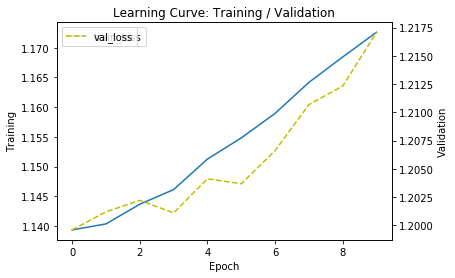

In [23]:
def plot_history(history):
    ## Plot Training Loss
    _, ax_l = plt.subplots(1)
    ax_l.plot(history.history['loss'], label='train_loss')
    ax_l.set_ylabel("Training")
    ax_l.set_xlabel("Epoch")
    ax_l.legend(loc=2)

    ## Plot Validation Loss
    ax_r = ax_l.twinx()
    ax_r.plot(history.history['val_loss'], 'y--', label='val_loss')
    ax_r.set_ylabel("Validation")
    ax_r.legend()
    
    plt.title("Learning Curve: Training / Validation")
    plt.show()

## Run!
plot_history(history)

## Restore Checkpoint

In [29]:
def restore_checkpoint(checkpoint, setup_lambda):
    model = setup_lambda()
    model.load_weights(checkpoint)
    model.build(tf.TensorShape([1, None]))
    return model

## Run!
if ('model' in globals()):
    print("Clean up old model!")
    tf.keras.backend.clear_session()
    del model
    pass

model = restore_checkpoint(
    './models/rnn_10',
    lambda: setup_rnn(inp_dim, emb_dim, units, batch_sz=1)
)

Clean up old model!


## Generate Text with RNN

In [36]:
def generate_text(model, seed, vocab, vocab_dict, length=100, temp=1.0):
    #vectorize the seed string
    vec_seed = np.array([vocab_dict[c] for c in seed])
    vec_seed = np.expand_dims(vec_seed, 0)
    print(vec_seed.shape)
    gen_text = []
    
    model.reset_states()
    for i in range(length):
        pred = model.predict(vec_seed)
        pred = tf.squeeze(pred, 0)

        # using a categorical distribution to predict the word returned by the model
        pred /= temp
        pred_id = tf.random.categorical(pred, num_samples=1)[-1,0].numpy()
        # We pass the predicted word as the next input to the model
        # along with the previous hidden state
        vec_seed = tf.expand_dims(pred_id, 0)
        gen_text.append(vocab[pred_id])
    return (seed + ''.join(gen_text))

## Run!
generate_text(model, "JULIET", vocab, vocab_dict)

(1, 6)


"JULIET:\nAlas, my lord.\n\nCAIUS LUCIO:\nI know no more, 'make nown a tow r I will chance\nAnd signify the crim"